# Seminar work - how to adapt the PO-LF-LM-EL-SH

@author: rosoba

This notebook is an adapted version of the notebook [3_1_PO_LF_LM_EL_FE_CB.ipynb](3_1_PO_LF_LM_EL_FE_CB.ipynb) and is prepared for adjustments needed to simulate the pull-out tests with parameters relevant for tasks specified within the seminar work.

## Idealization of the pull-out problem
The one-dimensional idealization of the pull-out looks as follows

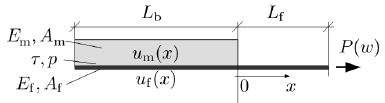

## Model parameters

The parameters and variables involved in the are grouped according geometry, material behavior, measured response, internal state and subsidiary integration parameters that will be resolved during the model derivation. In this classification we also associate the mathematical symbols with the Python variable name introduced in the next cell.

**Geometrical variables:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `A_f` | $A_\mathrm{f}$ |  Cross section area modulus of the reinforcement |
| `A_m` | $A_\mathrm{m}$ |  Cross section area modulus of the matrix |
| `p_b` | $p_\mathrm{b}$ |  Perimeter of the reinforcement                  |
| `L_b` | $L_\mathrm{b}$ |  Length of the bond zone of the pulled-out bar   |
| `x`   | $x$            |  Longitudinal coordinate |

**Material parameters:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `E_f`     | $E_\mathrm{f}$ |  Young's modulus of the reinforcement |
| `E_m`     | $E_\mathrm{m}$ |  Young's modulus of the matrix        |
| `MATS`    | $\tau(s)$      |  Multi-linear bond-slip model         |

(`MATS` is used to denote "Material Time Stepper" -- equivalent to user-subroutine in Abaqus, or user material in ATENA) 

**Control parameter:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `P` | $P$ | Pullout force |
| `w` | $w$ | pullout control  displacement

**State parameter:**

There are no state parameters included. 

 - What is the consequence? The material has no memory.
 - What happens upon unloading?

**Let's import the packages:**

In [145]:
%matplotlib notebook
import numpy as np # numerical package
import matplotlib.pyplot as plt # plotting package

## Numerical model of pull-out provided in BMCS Tool Suite 
The presented function is the simplest model provided in a general-purpose nonlinear finite-element simulator `BMCS-Tool-Suite`. This code can be installed in your anaconda environment by issuing the installation command

`pip install --upgrade bmcs`

After the installation it should be possible to import the `PullOutModel` by issuing

In [146]:
from bmcs.api import PullOutModel 

## Example test parameters
Let us consider the case of the RILEM pullout test with the boundary condition with the following material parameters 
\begin{align}
d &= 16\;\mathrm{mm} \\
E_\mathrm{f} &= 210\;\mathrm{GPa} \\
E_\mathrm{m} &= 28\;\mathrm{GPa} \\
A_\mathrm{f} &= \pi (\frac{d}{2})^2 \;\mathrm{mm}^2 \\
A_\mathrm{m} &= (10d)^2 \;\mathrm{mm}^2 \\
p &= \pi d
\end{align}

In [147]:
po = PullOutModel(mats_eval_type='multilinear',
                        n_e_x=50, k_max=200, w_max=0.1)
d = 14.0 # [mm]
E_f = 210000 # [MPa]
E_m = 38000 # [MPa]
P_b = np.pi * d # [mm]
A_f = np.pi*(d/2)**2
A_m = 300 * 200 # [mm]
po.cross_section.trait_set(A_f=A_f, A_m=A_m, P_b=P_b)

In [148]:
po.geometry.trait_set(L_x=50*d)

In [149]:
P_b * 10*d

6157.5216010359945

## Adapt the bond-slip law

In [150]:
po.mats_eval.s_tau_table = [[0, 0.01, 0.1, 0.11, 0.5, 1.0, 10],
                            [0,  8, 10, 10, 1, 0, 0]]

<IPython.core.display.Javascript object>


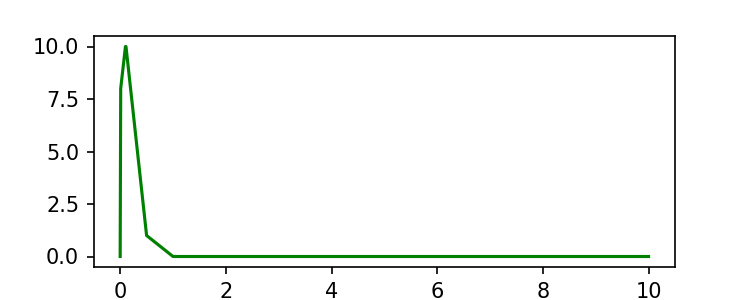

In [151]:
fig, ax = plt.subplots(1,1,figsize=(5,2))
po.mats_eval.bs_law.plot(ax, color='green')

# Load specification

In [152]:
po.sim.tline.step = 0.05
po.fixed_boundary = 'loaded end (matrix)'
po.loading_scenario.trait_set(loading_type='monotonic',
                              amplitude_type='constant',
                              loading_range='non-symmetric'
                              )
po.loading_scenario.trait_set(number_of_cycles=1,
                              unloading_ratio=0.98,
                              )

In [153]:
po.w_max = 1.8
po

## Run the simulation
The model object `po` contains the non-linear threaded simulator `sim` as its attribute. To be sure that the state arrays and history variables are zeroed and reset run the methods `stop` first. After that, the simulation can be started.

In [154]:
po.sim.run()

## Postprocessing

### Pull-out curve

<IPython.core.display.Javascript object>


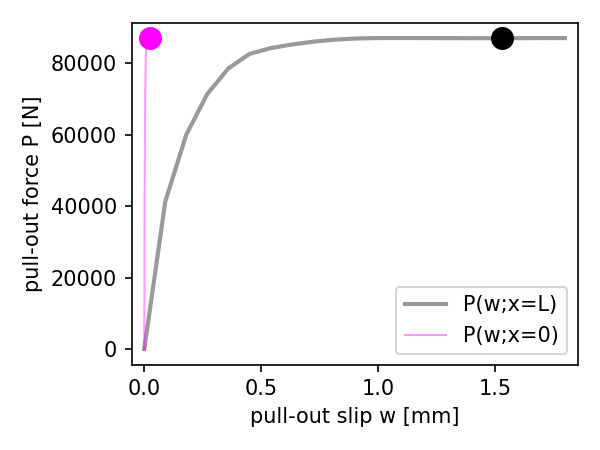

In [155]:
fix, ax = plt.subplots(1,1, figsize=(4,3),tight_layout=True)
po.hist.plot_Pw(ax, 0.9)

### Fiber and matrix stress at time $t$

<IPython.core.display.Javascript object>


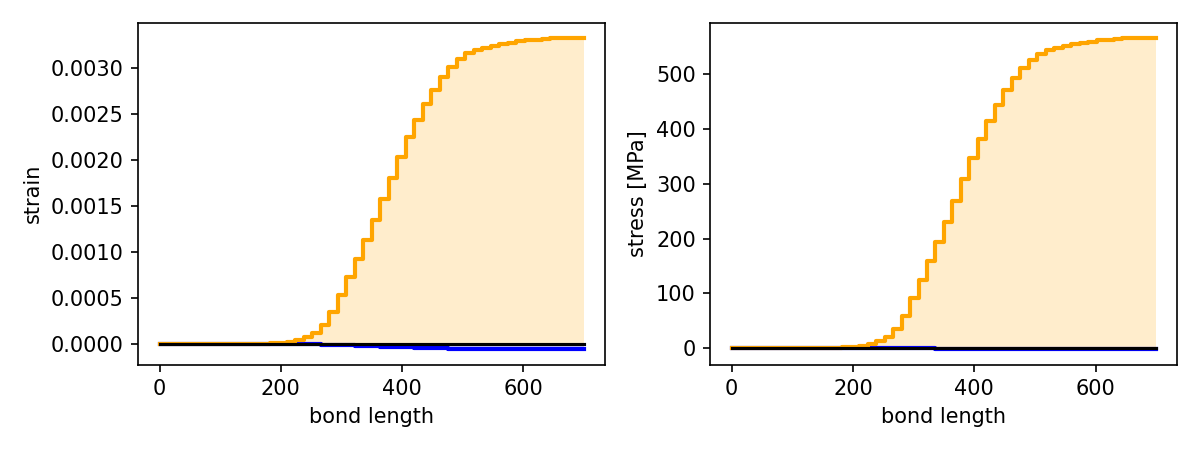

In [156]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3),tight_layout=True)
po.plot_eps_p(ax1, 0.6) # last argument between 0 and 1 defines the selected state during the simulation
po.plot_sig_p(ax2, 0.6);

### Slip and shear flow 

<IPython.core.display.Javascript object>


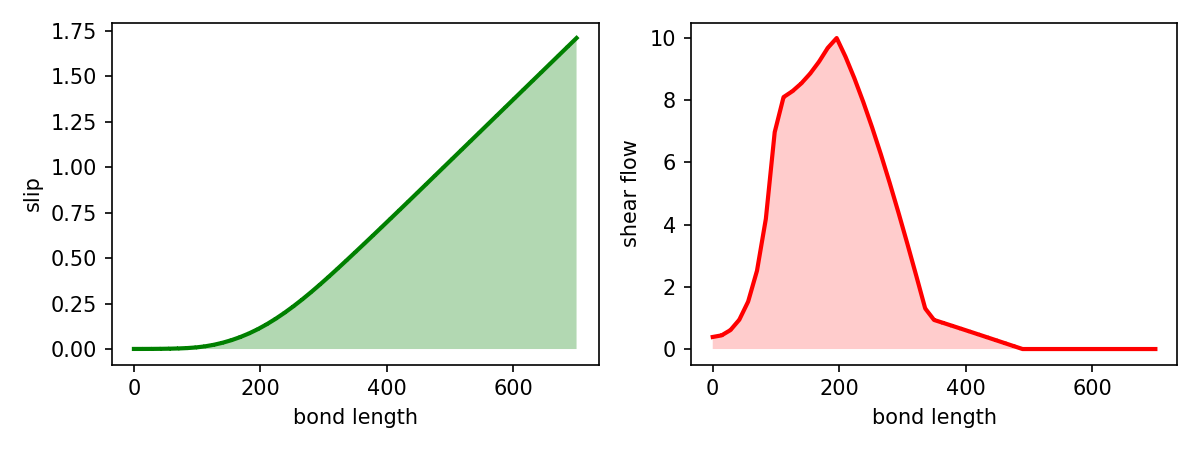

In [143]:
fix, (ax3, ax4) = plt.subplots(1,2, figsize=(8,3),tight_layout=True)
po.plot_s(ax3, 0.98)
po.plot_sf(ax4, 0.98);

### Energy dissipation

<IPython.core.display.Javascript object>


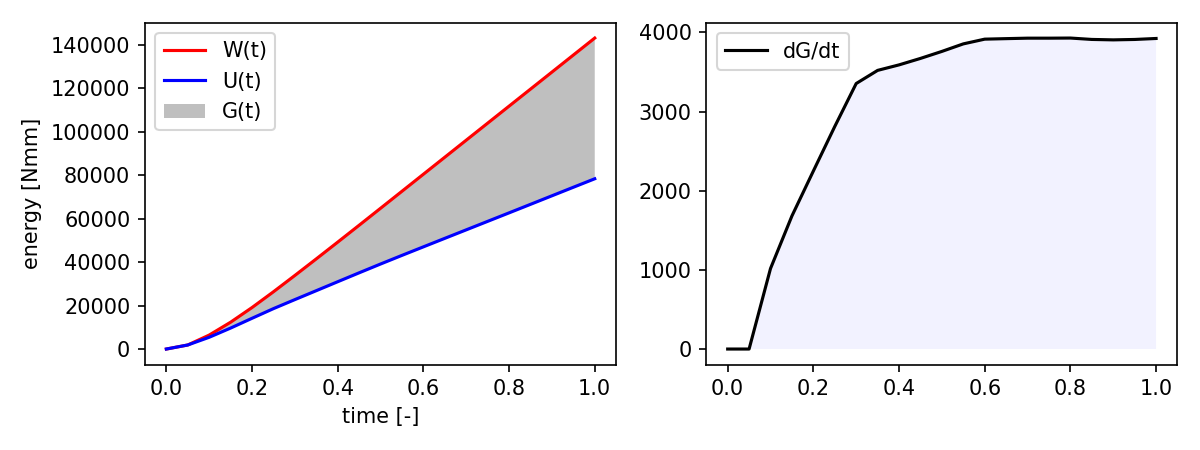

In [144]:
fix, (ax5, ax6) = plt.subplots(1,2, figsize=(8,3),tight_layout=True)
po.hist.plot_G_t(ax5, 1)
po.hist.plot_dG_t(ax6, 1);